# Method 5 - Best Ideas High Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

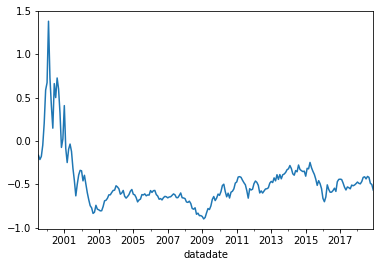

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.588367
2000-12-31   -0.355058
2001-12-31   -0.354468
2002-12-31   -0.677876
2003-12-31    1.030788
2004-12-31    0.018193
2005-12-31   -0.147644
2006-12-31   -0.050841
2007-12-31   -0.039927
2008-12-31   -0.594255
2009-12-31    1.789397
2010-12-31    0.327522
2011-12-31   -0.136929
2012-12-31    0.157296
2013-12-31    0.301976
2014-12-31   -0.024479
2015-12-31   -0.309831
2016-12-31    0.237481
2017-12-31   -0.088670
2018-12-31   -0.145230
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     169.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.73e-67
Time:                        04:13:50   Log-Likelihood:                 289.91
No. Observations:                 234   AIC:                            -569.8
Df Residuals:                     229   BIC:                            -552.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.005      0.838      0.403      -0.005       0.014
mktrf          1.4077      0.132     10.652      0.000       1.147       1.668
me             0.9067      0.154      5.898      0.000       0.604       1.210
ia            -0.2937      0.234     -1.257      0.210      -0.754       0.167
roe           -1.8469      0.200     -9.235      0.000      -2.241      -1.453
==============================================================================
Omnibus:                      142.883   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1734.722
Skew:                           2.144   Prob(JB):                         0.00
Kurtosis:                      15.631   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     90.06
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.17e-46
Time:                        04:13:50   Log-Likelihood:                 289.91
No. Observations:                 234   AIC:                            -569.8
Df Residuals:                     229   BIC:                            -552.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.005      0.887      0.375      -0.005       0.013
mktrf          1.4077      0.248      5.674      0.000       0.921       1.894
me             0.9067      0.234      3.874      0.000       0.448       1.365
ia            -0.2937      0.311     -0.945      0.345      -0.903       0.315
roe           -1.8469      0.269     -6.874      0.000      -2.373      -1.320
==============================================================================
Omnibus:                      142.883   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1734.722
Skew:                           2.144   Prob(JB):                         0.00
Kurtosis:                      15.631   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     103.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.22e-50
Time:                        04:13:50   Log-Likelihood:                 289.91
No. Observations:                 234   AIC:                            -569.8
Df Residuals:                     229   BIC:                            -552.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.005      0.814      0.416      -0.006       0.014
mktrf          1.4077      0.247      5.708      0.000       0.924       1.891
me             0.9067      0.246      3.686      0.000       0.425       1.389
ia            -0.2937      0.329     -0.893      0.372      -0.939       0.351
roe           -1.8469      0.289     -6.399      0.000      -2.413      -1.281
==============================================================================
Omnibus:                      142.883   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1734.722
Skew:                           2.144   Prob(JB):                         0.00
Kurtosis:                      15.631   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     133.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.42e-66
Time:                        04:13:50   Log-Likelihood:                 289.41
No. Observations:                 234   AIC:                            -566.8
Df Residuals:                     228   BIC:                            -546.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.005      0.696      0.487      -0.006       0.013
mktrf          1.5754      0.133     11.846      0.000       1.313       1.837
smb            0.8637      0.175      4.922      0.000       0.518       1.209
hml            0.0624      0.207      0.301      0.763      -0.345       0.470
rmw           -1.8650      0.234     -7.972      0.000      -2.326      -1.404
cma            0.1310      0.297      0.440      0.660      -0.455       0.717
==============================================================================
Omnibus:                      132.713   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1105.205
Skew:                           2.090   Prob(JB):                    1.02e-240
Kurtosis:                      12.792   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     126.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.02e-63
Time:                        04:13:50   Log-Likelihood:                 289.41
No. Observations:                 234   AIC:                            -566.8
Df Residuals:                     228   BIC:                            -546.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.005      0.676      0.499      -0.007       0.013
mktrf          1.5754      0.157     10.055      0.000       1.268       1.883
smb            0.8637      0.186      4.647      0.000       0.499       1.228
hml            0.0624      0.346      0.180      0.857      -0.616       0.741
rmw           -1.8650      0.246     -7.579      0.000      -2.347      -1.383
cma            0.1310      0.373      0.351      0.726      -0.601       0.863
==============================================================================
Omnibus:                      132.713   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1105.205
Skew:                           2.090   Prob(JB):                    1.02e-240
Kurtosis:                      12.792   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     138.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.31e-67
Time:                        04:13:50   Log-Likelihood:                 289.41
No. Observations:                 234   AIC:                            -566.8
Df Residuals:                     228   BIC:                            -546.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.006      0.609      0.543      -0.008       0.014
mktrf          1.5754      0.145     10.848      0.000       1.291       1.860
smb            0.8637      0.190      4.535      0.000       0.490       1.237
hml            0.0624      0.296      0.211      0.833      -0.518       0.643
rmw           -1.8650      0.245     -7.600      0.000      -2.346      -1.384
cma            0.1310      0.327      0.400      0.689      -0.510       0.772
==============================================================================
Omnibus:                      132.713   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1105.205
Skew:                           2.090   Prob(JB):                    1.02e-240
Kurtosis:                      12.792   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     149.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.24e-62
Time:                        04:13:50   Log-Likelihood:                 279.24
No. Observations:                 234   AIC:                            -548.5
Df Residuals:                     229   BIC:                            -531.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.005     -0.567      0.571      -0.013       0.007
mktrf          1.7534      0.127     13.768      0.000       1.502       2.004
smb            1.7331      0.159     10.902      0.000       1.420       2.046
hml           -0.3459      0.158     -2.191      0.029      -0.657      -0.035
umd           -0.5768      0.104     -5.566      0.000      -0.781      -0.373
==============================================================================
Omnibus:                      124.580   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1111.102
Skew:                           1.893   Prob(JB):                    5.34e-242
Kurtosis:                      12.981   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     62.77
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.42e-36
Time:                        04:13:50   Log-Likelihood:                 279.24
No. Observations:                 234   AIC:                            -548.5
Df Residuals:                     229   BIC:                            -531.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.004     -0.656      0.512      -0.011       0.006
mktrf          1.7534      0.202      8.701      0.000       1.358       2.148
smb            1.7331      0.215      8.054      0.000       1.311       2.155
hml           -0.3459      0.255     -1.356      0.175      -0.846       0.154
umd           -0.5768      0.153     -3.759      0.000      -0.877      -0.276
==============================================================================
Omnibus:                      124.580   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1111.102
Skew:                           1.893   Prob(JB):                    5.34e-242
Kurtosis:                      12.981   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     63.20
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.26e-36
Time:                        04:13:50   Log-Likelihood:                 279.24
No. Observations:                 234   AIC:                            -548.5
Df Residuals:                     229   BIC:                            -531.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028      0.004     -0.626      0.532      -0.012       0.006
mktrf          1.7534      0.200      8.774      0.000       1.362       2.145
smb            1.7331      0.205      8.460      0.000       1.332       2.135
hml           -0.3459      0.251     -1.376      0.169      -0.839       0.147
umd           -0.5768      0.163     -3.543      0.000      -0.896      -0.258
==============================================================================
Omnibus:                      124.580   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1111.102
Skew:                           1.893   Prob(JB):                    5.34e-242
Kurtosis:                      12.981   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     90.44
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.37e-34
Time:                        04:13:50   Log-Likelihood:                 132.06
No. Observations:                 120   AIC:                            -254.1
Df Residuals:                     115   BIC:                            -240.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.008      1.067      0.288      -0.007       0.024
mktrf          1.2421      0.212      5.860      0.000       0.822       1.662
me             0.8812      0.209      4.209      0.000       0.467       1.296
ia            -0.7677      0.328     -2.342      0.021      -1.417      -0.118
roe           -1.8145      0.290     -6.253      0.000      -2.389      -1.240
==============================================================================
Omnibus:                       74.469   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              545.915
Skew:                           1.970   Prob(JB):                    2.86e-119
Kurtosis:                      12.678   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     107.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.67e-38
Time:                        04:13:50   Log-Likelihood:                 132.06
No. Observations:                 120   AIC:                            -254.1
Df Residuals:                     115   BIC:                            -240.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.007      1.244      0.214      -0.005       0.022
mktrf          1.2421      0.394      3.149      0.002       0.469       2.015
me             0.8812      0.299      2.944      0.003       0.295       1.468
ia            -0.7677      0.402     -1.912      0.056      -1.555       0.019
roe           -1.8145      0.379     -4.790      0.000      -2.557      -1.072
==============================================================================
Omnibus:                       74.469   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              545.915
Skew:                           1.970   Prob(JB):                    2.86e-119
Kurtosis:                      12.678   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     223.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.91e-53
Time:                        04:13:51   Log-Likelihood:                 132.06
No. Observations:                 120   AIC:                            -254.1
Df Residuals:                     115   BIC:                            -240.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0084      0.007      1.174      0.240      -0.006       0.022
mktrf          1.2421      0.399      3.111      0.002       0.460       2.025
me             0.8812      0.316      2.793      0.005       0.263       1.500
ia            -0.7677      0.380     -2.019      0.043      -1.513      -0.023
roe           -1.8145      0.430     -4.222      0.000      -2.657      -0.972
==============================================================================
Omnibus:                       74.469   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              545.915
Skew:                           1.970   Prob(JB):                    2.86e-119
Kurtosis:                      12.678   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     77.23
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.68e-35
Time:                        04:13:51   Log-Likelihood:                 135.46
No. Observations:                 120   AIC:                            -258.9
Df Residuals:                     114   BIC:                            -242.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.008      1.205      0.231      -0.006       0.025
mktrf          1.6529      0.218      7.574      0.000       1.221       2.085
smb            0.9266      0.247      3.749      0.000       0.437       1.416
hml           -0.4996      0.303     -1.649      0.102      -1.100       0.100
rmw           -1.4288      0.357     -4.000      0.000      -2.136      -0.721
cma            0.1335      0.391      0.341      0.734      -0.642       0.909
==============================================================================
Omnibus:                       73.076   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.950
Skew:                           2.061   Prob(JB):                     3.17e-88
Kurtosis:                      10.975   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     91.83
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.55e-38
Time:                        04:13:51   Log-Likelihood:                 135.46
No. Observations:                 120   AIC:                            -258.9
Df Residuals:                     114   BIC:                            -242.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.007      1.384      0.166      -0.004       0.023
mktrf          1.6529      0.284      5.815      0.000       1.096       2.210
smb            0.9266      0.264      3.511      0.000       0.409       1.444
hml           -0.4996      0.246     -2.028      0.043      -0.982      -0.017
rmw           -1.4288      0.322     -4.438      0.000      -2.060      -0.798
cma            0.1335      0.393      0.339      0.734      -0.637       0.904
==============================================================================
Omnibus:                       73.076   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.950
Skew:                           2.061   Prob(JB):                     3.17e-88
Kurtosis:                      10.975   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     91.13
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.59e-38
Time:                        04:13:51   Log-Likelihood:                 135.46
No. Observations:                 120   AIC:                            -258.9
Df Residuals:                     114   BIC:                            -242.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.008      1.249      0.212      -0.005       0.024
mktrf          1.6529      0.248      6.657      0.000       1.166       2.140
smb            0.9266      0.251      3.695      0.000       0.435       1.418
hml           -0.4996      0.168     -2.969      0.003      -0.829      -0.170
rmw           -1.4288      0.326     -4.385      0.000      -2.067      -0.790
cma            0.1335      0.311      0.429      0.668      -0.476       0.743
==============================================================================
Omnibus:                       73.076   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              402.950
Skew:                           2.061   Prob(JB):                     3.17e-88
Kurtosis:                      10.975   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     99.49
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.09e-36
Time:                        04:13:51   Log-Likelihood:                 136.45
No. Observations:                 120   AIC:                            -262.9
Df Residuals:                     115   BIC:                            -249.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.007      0.395      0.694      -0.012       0.018
mktrf          1.7669      0.180      9.814      0.000       1.410       2.123
smb            1.6791      0.205      8.192      0.000       1.273       2.085
hml           -0.8134      0.205     -3.962      0.000      -1.220      -0.407
umd           -0.5222      0.127     -4.125      0.000      -0.773      -0.271
==============================================================================
Omnibus:                       71.529   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              523.625
Skew:                           1.865   Prob(JB):                    1.98e-114
Kurtosis:                      12.529   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     77.11
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.20e-31
Time:                        04:13:51   Log-Likelihood:                 136.45
No. Observations:                 120   AIC:                            -262.9
Df Residuals:                     115   BIC:                            -249.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.006      0.489      0.625      -0.009       0.015
mktrf          1.7669      0.290      6.102      0.000       1.199       2.334
smb            1.6791      0.207      8.093      0.000       1.272       2.086
hml           -0.8134      0.278     -2.930      0.003      -1.357      -0.269
umd           -0.5222      0.159     -3.292      0.001      -0.833      -0.211
==============================================================================
Omnibus:                       71.529   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              523.625
Skew:                           1.865   Prob(JB):                    1.98e-114
Kurtosis:                      12.529   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     146.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.63e-44
Time:                        04:13:51   Log-Likelihood:                 136.45
No. Observations:                 120   AIC:                            -262.9
Df Residuals:                     115   BIC:                            -249.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.006      0.463      0.644      -0.009       0.015
mktrf          1.7669      0.290      6.099      0.000       1.199       2.335
smb            1.6791      0.179      9.400      0.000       1.329       2.029
hml           -0.8134      0.229     -3.545      0.000      -1.263      -0.364
umd           -0.5222      0.178     -2.941      0.003      -0.870      -0.174
==============================================================================
Omnibus:                       71.529   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              523.625
Skew:                           1.865   Prob(JB):                    1.98e-114
Kurtosis:                      12.529   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     83.98
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.15e-32
Time:                        04:13:51   Log-Likelihood:                 172.80
No. Observations:                 114   AIC:                            -335.6
Df Residuals:                     109   BIC:                            -321.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.005     -0.250      0.803      -0.012       0.009
mktrf          1.6176      0.160     10.123      0.000       1.301       1.934
me             0.7787      0.247      3.156      0.002       0.290       1.268
ia             0.6528      0.342      1.907      0.059      -0.026       1.331
roe           -1.9889      0.301     -6.614      0.000      -2.585      -1.393
==============================================================================
Omnibus:                       26.381   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.500
Skew:                           0.909   Prob(JB):                     5.39e-13
Kurtosis:                       5.931   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     75.07
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.98e-30
Time:                        04:13:51   Log-Likelihood:                 172.80
No. Observations:                 114   AIC:                            -335.6
Df Residuals:                     109   BIC:                            -321.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.004     -0.336      0.737      -0.009       0.007
mktrf          1.6176      0.177      9.122      0.000       1.270       1.965
me             0.7787      0.340      2.291      0.022       0.112       1.445
ia             0.6528      0.377      1.733      0.083      -0.086       1.391
roe           -1.9889      0.577     -3.448      0.001      -3.119      -0.858
==============================================================================
Omnibus:                       26.381   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.500
Skew:                           0.909   Prob(JB):                     5.39e-13
Kurtosis:                       5.931   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     81.37
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.78e-32
Time:                        04:13:51   Log-Likelihood:                 172.80
No. Observations:                 114   AIC:                            -335.6
Df Residuals:                     109   BIC:                            -321.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.004     -0.367      0.713      -0.009       0.006
mktrf          1.6176      0.169      9.552      0.000       1.286       1.950
me             0.7787      0.388      2.005      0.045       0.018       1.540
ia             0.6528      0.415      1.573      0.116      -0.161       1.466
roe           -1.9889      0.578     -3.444      0.001      -3.121      -0.857
==============================================================================
Omnibus:                       26.381   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.500
Skew:                           0.909   Prob(JB):                     5.39e-13
Kurtosis:                       5.931   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     67.24
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.41e-31
Time:                        04:13:51   Log-Likelihood:                 173.23
No. Observations:                 114   AIC:                            -334.5
Df Residuals:                     108   BIC:                            -318.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.005     -0.698      0.486      -0.015       0.007
mktrf          1.6526      0.153     10.835      0.000       1.350       1.955
smb            0.6757      0.248      2.729      0.007       0.185       1.167
hml            1.0840      0.316      3.433      0.001       0.458       1.710
rmw           -1.8005      0.387     -4.656      0.000      -2.567      -1.034
cma           -0.0053      0.491     -0.011      0.991      -0.978       0.968
==============================================================================
Omnibus:                       43.524   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.746
Skew:                           1.103   Prob(JB):                     2.37e-52
Kurtosis:                       9.722   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     83.40
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.82e-35
Time:                        04:13:51   Log-Likelihood:                 173.23
No. Observations:                 114   AIC:                            -334.5
Df Residuals:                     108   BIC:                            -318.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.005     -0.696      0.486      -0.014       0.007
mktrf          1.6526      0.132     12.514      0.000       1.394       1.911
smb            0.6757      0.257      2.629      0.009       0.172       1.179
hml            1.0840      0.249      4.351      0.000       0.596       1.572
rmw           -1.8005      0.486     -3.706      0.000      -2.753      -0.848
cma           -0.0053      0.395     -0.013      0.989      -0.779       0.769
==============================================================================
Omnibus:                       43.524   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.746
Skew:                           1.103   Prob(JB):                     2.37e-52
Kurtosis:                       9.722   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     103.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.28e-39
Time:                        04:13:51   Log-Likelihood:                 173.23
No. Observations:                 114   AIC:                            -334.5
Df Residuals:                     108   BIC:                            -318.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.005     -0.708      0.479      -0.014       0.007
mktrf          1.6526      0.139     11.860      0.000       1.380       1.926
smb            0.6757      0.293      2.304      0.021       0.101       1.251
hml            1.0840      0.220      4.933      0.000       0.653       1.515
rmw           -1.8005      0.467     -3.853      0.000      -2.716      -0.885
cma           -0.0053      0.399     -0.013      0.989      -0.788       0.778
==============================================================================
Omnibus:                       43.524   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.746
Skew:                           1.103   Prob(JB):                     2.37e-52
Kurtosis:                       9.722   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     72.12
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.66e-30
Time:                        04:13:51   Log-Likelihood:                 166.37
No. Observations:                 114   AIC:                            -322.7
Df Residuals:                     109   BIC:                            -309.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0053      0.006     -0.936      0.352      -0.017       0.006
mktrf          1.7147      0.160     10.703      0.000       1.397       2.032
smb            1.0915      0.250      4.369      0.000       0.596       1.587
hml            1.0792      0.257      4.194      0.000       0.569       1.589
umd           -0.5511      0.194     -2.839      0.005      -0.936      -0.166
==============================================================================
Omnibus:                       48.072   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.991
Skew:                           1.228   Prob(JB):                     9.63e-62
Kurtosis:                      10.289   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     105.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.43e-36
Time:                        04:13:51   Log-Likelihood:                 166.37
No. Observations:                 114   AIC:                            -322.7
Df Residuals:                     109   BIC:                            -309.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0053      0.005     -1.088      0.277      -0.015       0.004
mktrf          1.7147      0.151     11.353      0.000       1.419       2.011
smb            1.0915      0.253      4.318      0.000       0.596       1.587
hml            1.0792      0.266      4.052      0.000       0.557       1.601
umd           -0.5511      0.154     -3.570      0.000      -0.854      -0.249
==============================================================================
Omnibus:                       48.072   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.991
Skew:                           1.228   Prob(JB):                     9.63e-62
Kurtosis:                      10.289   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     115.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.01e-38
Time:                        04:13:51   Log-Likelihood:                 166.37
No. Observations:                 114   AIC:                            -322.7
Df Residuals:                     109   BIC:                            -309.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0053      0.005     -1.114      0.265      -0.015       0.004
mktrf          1.7147      0.154     11.113      0.000       1.412       2.017
smb            1.0915      0.248      4.402      0.000       0.606       1.577
hml            1.0792      0.270      3.990      0.000       0.549       1.609
umd           -0.5511      0.140     -3.925      0.000      -0.826      -0.276
==============================================================================
Omnibus:                       48.072   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.991
Skew:                           1.228   Prob(JB):                     9.63e-62
Kurtosis:                      10.289   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""